In [1]:
# data
import nfl_data_py as nfl

# data loading and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# models
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# interpretation
import shap
from interpret import show

# pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, nan_euclidean_distances

pd.set_option('display.max_columns', None)  # None zeigt alle Spalten
pd.set_option('display.max_rows', None)  # Alle Zeilen anzeigen, vorsichtig bei großen DataFrames
pd.set_option('display.width', 1000)  # Breite anpassen


In [2]:
df_ids = nfl.import_ids()
df_weekly = nfl.import_weekly_data(list(range(2018, 2025)))
df_seasonal = nfl.import_seasonal_data(list(range(2017,2024)))
df_schedule = nfl.import_schedules(list(range(2018, 2025)))
df_pass_pfr = nfl.import_weekly_pfr('pass', list(range(2018, 2025)))
df_rush_pfr = nfl.import_weekly_pfr('rush', list(range(2018, 2025)))
df_rec_pfr = nfl.import_weekly_pfr('rec', list(range(2018, 2025)))
df_pass_ngs = nfl.import_ngs_data('passing',list(range(2018, 2025)))
df_rush_ngs = nfl.import_ngs_data('rushing',list(range(2018, 2025)))
df_rec_ngs = nfl.import_ngs_data('receiving',list(range(2018, 2025)))
df_snap_counts = nfl.import_snap_counts(list(range(2018, 2025)))

df_weekly = df_weekly[(df_weekly['season_type'] == 'REG') & (df_weekly['position'].isin(['QB', 'WR', 'RB', 'TE']))]

df_weekly['game_id_home_away'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['recent_team']+'_'+df_weekly['opponent_team']
df_weekly['game_id_away_home'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['opponent_team']+'_'+df_weekly['recent_team']

df_ids = df_ids.rename(columns={'gsis_id': 'player_id', 'pfr_id': 'pfr_player_id'})
df_pass_ngs = df_pass_ngs.rename(columns={'player_gsis_id': 'player_id'})
df_rush_ngs = df_rush_ngs.rename(columns={'player_gsis_id': 'player_id'})
df_rec_ngs = df_rec_ngs.rename(columns={'player_gsis_id': 'player_id'})

df_seasonal['season'] = df_seasonal['season'] + 1

df_merged = pd.melt(
    df_weekly,
    id_vars=['player_id', 'position', 'season', 'week', 'recent_team', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_2pt_conversions', 'interceptions', 'sack_fumbles_lost', 'sacks', 'sack_yards', 'passing_air_yards', 'passing_epa', 'pacr', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_2pt_conversions', 'rushing_fumbles_lost', 'rushing_epa', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_2pt_conversions', 'receiving_fumbles_lost', 'racr', 'wopr', 'receiving_epa', 'fantasy_points'],
    value_vars=['game_id_home_away', 'game_id_away_home'],
    var_name='game_id_type',
    value_name='game_id'
)

df_merged = pd.merge(df_merged, df_ids[['player_id', 'pfr_player_id', 'draft_pick', 'draft_year']], on = 'player_id', how = 'inner')
df_merged = pd.merge(df_merged, df_seasonal[['player_id', 'season', 'dom']], on = ['player_id', 'season'], how = 'left')
df_merged = pd.merge(df_merged, df_schedule[['game_id', 'home_team']], on='game_id', how='inner')
df_merged = pd.merge(df_merged, df_pass_pfr[['pfr_player_id', 'season', 'week', 'passing_bad_throws', 'times_pressured']], on = ['pfr_player_id', 'season', 'week'], how = 'left')
df_merged = pd.merge(df_merged, df_rec_pfr[['pfr_player_id', 'season', 'week', 'receiving_rat']], on = ['pfr_player_id', 'season', 'week'], how = 'left')
df_merged = pd.merge(df_merged, df_rush_pfr[['pfr_player_id', 'season', 'week', 'rushing_broken_tackles']], on = ['pfr_player_id', 'season', 'week'], how = 'left')
df_merged = pd.merge(df_merged, df_pass_ngs[['player_id', 'season', 'week', 'passer_rating', 'aggressiveness']], on = ['player_id', 'season', 'week'], how = 'left')
df_merged = pd.merge(df_merged, df_rec_ngs[['player_id', 'season', 'week', 'catch_percentage']], on = ['player_id', 'season', 'week'], how = 'left')
df_merged = pd.merge(df_merged, df_rush_ngs[['player_id', 'season', 'week', 'efficiency']], on = ['player_id', 'season', 'week'], how = 'left')
df_merged = pd.merge(df_merged, df_snap_counts[['pfr_player_id', 'season', 'week', 'offense_snaps']], on = ['pfr_player_id', 'season', 'week'], how = 'left')

df_merged = df_merged.drop(columns=['game_id', 'game_id_type', 'pfr_player_id'])

df_merged.info()

Downcasting floats.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35195 entries, 0 to 35194
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_id                  35195 non-null  object 
 1   position                   35195 non-null  object 
 2   season                     35195 non-null  int32  
 3   week                       35195 non-null  int32  
 4   recent_team                35195 non-null  object 
 5   opponent_team              35195 non-null  object 
 6   completions                35195 non-null  int32  
 7   attempts                   35195 non-null  int32  
 8   passing_yards              35195 non-null  float32
 9   passing_tds                35195 non-null  int32  
 10  passing_2pt_conversions    35195 non-null  int32  
 11  interceptions              35195 non-null  float32
 12  sack_fumbles_lost          35195 non-null  int32  
 13  sacks                     

In [3]:
df_merged = df_merged.fillna(0)

df_merged['rookie_flag'] = (df_merged['season'] == df_merged['draft_year']).astype(int)
df_merged['last_season_data_flag'] = (df_merged['week'] < 6).astype(int)

recent_team_means = df_merged.groupby(['recent_team', 'season', 'week'])['fantasy_points'].mean().reset_index()
opponent_team_means = df_merged.groupby(['opponent_team', 'season', 'week'])['fantasy_points'].mean().reset_index()
position_means = df_merged.groupby(['position', 'season', 'week'])['fantasy_points'].mean().reset_index()

recent_team_means.rename(columns={'fantasy_points': 'recent_team_encoded'}, inplace=True)
opponent_team_means.rename(columns={'fantasy_points': 'opponent_team_encoded'}, inplace=True)
position_means.rename(columns={'fantasy_points': 'position_encoded'}, inplace=True)

df_merged = pd.merge(df_merged, recent_team_means, on=['recent_team', 'season', 'week'], how='left')
df_merged = pd.merge(df_merged, opponent_team_means, on=['opponent_team', 'season', 'week'], how='left')
df_merged = pd.merge(df_merged, position_means, on=['position', 'season', 'week'], how='left')

df_merged['turnover'] = (
    df_merged['interceptions'] +
    df_merged['sack_fumbles_lost'] +
    df_merged['rushing_fumbles_lost'] +
    df_merged['receiving_fumbles_lost']
)

df_merged['rushing_pts'] = (df_merged['rushing_tds'] * 6) + (df_merged['rushing_2pt_conversions'] * 2)
df_merged['receiving_pts'] = (df_merged['receiving_tds'] * 6) + (df_merged['receiving_2pt_conversions'] * 2)
df_merged['passing_pts'] = (df_merged['passing_tds'] * 6) + (df_merged['passing_2pt_conversions'] * 2)

df_merged['epa_total'] = df_merged['passing_epa'] + df_merged['rushing_epa'] + df_merged['receiving_epa']

df_merged = df_merged.drop(columns=['draft_year', 'interceptions', 'sack_fumbles_lost', 'rushing_fumbles_lost', 'receiving_fumbles_lost', 
                                    'rushing_tds', 'rushing_2pt_conversions', 'receiving_tds', 'receiving_2pt_conversions', 'passing_tds', 
                                    'passing_2pt_conversions', 'passing_epa', 'rushing_epa', 'receiving_epa'])

# Liste der Spalten, für die Rolling-Features erstellt werden sollen
columns_to_roll = ['completions', 'attempts', 'passing_yards', 'sacks', 'passer_rating', 'aggressiveness', 'catch_percentage', 'efficiency',
                   'sack_yards', 'passing_air_yards', 'pacr', 'carries', 'offense_snaps', 'recent_team_encoded', 
                   'opponent_team_encoded', 'rushing_yards', 'receptions', 'targets', 'receiving_yards', 
                   'racr', 'wopr', 'fantasy_points', 'passing_bad_throws', 'times_pressured', 'position_encoded', 'epa_total',
                   'receiving_rat', 'rushing_broken_tackles', 'turnover', 'rushing_pts', 'receiving_pts', 'passing_pts']

# Funktion zum Erstellen von Rolling-Features
def create_rolling_features(df):
    # Sortiere nach player_id, season und week
    df = df.sort_values(by=['player_id', 'season', 'week']).reset_index(drop=True)

    df['cnt_games_over_20ffpts_l5w'] = (
        df.groupby('player_id')['fantasy_points']
        .apply(lambda x: x.shift(1).rolling(window=5, min_periods=5).apply(lambda y: (y > 20).sum()))
        .reset_index(level=0, drop=True)
    )

    # Rolling-Features erstellen
    for col in columns_to_roll:

        feature_name_1 = f"ewm_{col}_l5w"
        df[feature_name_1] = (
            df.groupby('player_id')[col]
            .apply(lambda x: x.shift(1).ewm(span=5, min_periods=5).mean())
            .reset_index(level=0, drop=True)
        )

        for metric in ['mean', 'median', 'std']:
            feature_name_2 = f"{metric}_{col}_l5w"
            rolling_result_5w = (
                df.groupby('player_id')[col]
                  .apply(lambda x: x.shift(1).rolling(window=5, min_periods=5).agg(metric))  # shift(1) schließt aktuelle Woche aus
                  .reset_index(level=0, drop=True)  # Index zurücksetzen
            )
            # Einfügen der Rolling-Metrik
            df[feature_name_2] = rolling_result_5w

        for metric in ['max', 'min']:
            feature_name_3 = f"{metric}_{col}_l3w"
            # Berechnung der Rolling-Metrik (ohne aktuelle Woche)
            rolling_result_3w = (
                df.groupby('player_id')[col]
                  .apply(lambda x: x.shift(1).rolling(window=3, min_periods=3).agg(metric))  # shift(1) schließt aktuelle Woche aus
                  .reset_index(level=0, drop=True)  # Index zurücksetzen
            )
            # Einfügen der Rolling-Metrik
            df[feature_name_3] = rolling_result_3w

    return df


# Anwendung auf df_merged
df_merged = create_rolling_features(df_merged)

df_merged.info()

/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_22616/1799494887.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name_3] = rolling_result_3w
/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_22616/1799494887.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name_3] = rolling_result_3w
/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_22616/1799494887.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35195 entries, 0 to 35194
Columns: 236 entries, player_id to min_passing_pts_l3w
dtypes: float32(14), float64(205), int32(10), int64(2), object(5)
memory usage: 60.1+ MB


/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_22616/1799494887.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name_3] = rolling_result_3w


In [4]:
df_merged = df_merged.dropna()

df_merged['player_id'] = df_merged['player_id'].str.replace('00-00', '').astype(int)
df_merged['home'] = (df_merged['home_team'] == df_merged['recent_team']).astype(int)

df_merged = df_merged.drop(columns=['completions', 'attempts', 'passing_yards', 'sacks', 'sack_yards', 'passing_air_yards',  
                                    'pacr', 'carries', 'rushing_yards', 'receptions', 'targets', 'receiving_yards', 'racr', 
                                    'wopr', 'passing_bad_throws', 'times_pressured', 'receiving_rat', 'rushing_broken_tackles', 'turnover', 
                                    'rushing_pts', 'receiving_pts', 'passing_pts', 'home_team', 'passer_rating', 'aggressiveness',
                                    'catch_percentage', 'efficiency', 'offense_snaps', 'recent_team_encoded', 'opponent_team_encoded', 
                                    'position_encoded', 'recent_team', 'opponent_team', 'position', 'epa_total'])

df_merged.info()


<class 'pandas.core.frame.DataFrame'>
Index: 29633 entries, 5 to 35194
Columns: 202 entries, player_id to home
dtypes: float32(1), float64(195), int32(2), int64(4)
memory usage: 45.6 MB


/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_22616/2602746769.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merged['home'] = (df_merged['home_team'] == df_merged['recent_team']).astype(int)


In [5]:
X_train = df_merged[df_merged['season'].isin([2018, 2019, 2020, 2021, 2022, 2023])].drop(columns=['fantasy_points'])
y_train = df_merged[df_merged['season'].isin([2018, 2019, 2020, 2021, 2022, 2023])]['fantasy_points']

X_val = df_merged[df_merged['season']==2023].drop(columns=['fantasy_points'])
y_val = df_merged[df_merged['season']==2023]['fantasy_points']

X_test = df_merged[df_merged['season']==2024].drop(columns=['fantasy_points'])
y_test = df_merged[df_merged['season']==2024]['fantasy_points']

In [6]:
# preprocessor = ColumnTransformer(transformers=[
#     ("num", SimpleImputer(strategy="median"), X_train.columns),
# ])

# xgb = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("scaler", StandardScaler()),
#     ("feature_selection", RFE(estimator=XGBRegressor(), n_features_to_select=60, step=1, verbose=2)),
#     ("model", XGBRegressor())
# ])

# xgb_grid = {
#     "model__max_depth": [3, 6, 7, None],
#     "model__learning_rate": [0.05, 0.1, 0.3],
#     "model__n_estimators": [100, 500, 1000]
# }

# xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_grid, verbose=2, cv=TimeSeriesSplit(n_splits=3))

# xgb_grid_search.fit(X_train, y_train)

# xgb_grid_search.score(X_test, y_test)

In [7]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns= X_test.columns)


In [8]:
# define a grid of hyperparameters and possible values
xgb_grid = {
    "max_depth": [3, 6, 7, None],
    "learning_rate": [0.05, 0.1, 0.3],
    "n_estimators": [100, 500, 1000]
}

gridSearch = GridSearchCV(XGBRegressor(), xgb_grid, verbose=2, cv=TimeSeriesSplit(n_splits=3))
gridSearch.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   1.0s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   1.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   1.5s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   1.9s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   2.3s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   2.7s
[CV] END ..learning_rate=0.05, max_depth=6, n_estimators=100; total time=   0.7s
[CV] END ..learning_rate=0.05, max_depth=6, n_estimators=100; total time=   0.8s
[CV] END ..learning_rate=0.05, max_depth=6, n_e

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.3],
                         'max_depth': [3, 6, 7, None],
                         'n_estimators': [100, 500, 1000]},
             verbose=2)

In [9]:
# get the best model and fit it on the complete  set
bestModel = gridSearch.best_estimator_.fit(X_train, y_train)
bestModel.score(X_test, y_test)

0.396820604801178

In [10]:
rfe = RFECV(bestModel, step=1, cv=TimeSeriesSplit(n_splits=5), scoring="r2")
rfe.fit(X_train, y_train)

# Ausgewählte Features anzeigen
best_features = X_train.columns[rfe.support_]
print("Ausgewählte Features:", best_features)
print(len(best_features))
print(rfe.score(X_test, y_test))

Ausgewählte Features: Index(['player_id', 'season', 'draft_pick', 'dom', 'rookie_flag', 'last_season_data_flag', 'cnt_games_over_20ffpts_l5w', 'ewm_completions_l5w', 'mean_completions_l5w', 'median_completions_l5w',
       ...
       'std_turnover_l5w', 'ewm_rushing_pts_l5w', 'std_rushing_pts_l5w', 'ewm_receiving_pts_l5w', 'mean_receiving_pts_l5w', 'std_receiving_pts_l5w', 'max_receiving_pts_l3w', 'ewm_passing_pts_l5w', 'std_passing_pts_l5w', 'home'], dtype='object', length=119)
119
0.396820604801178


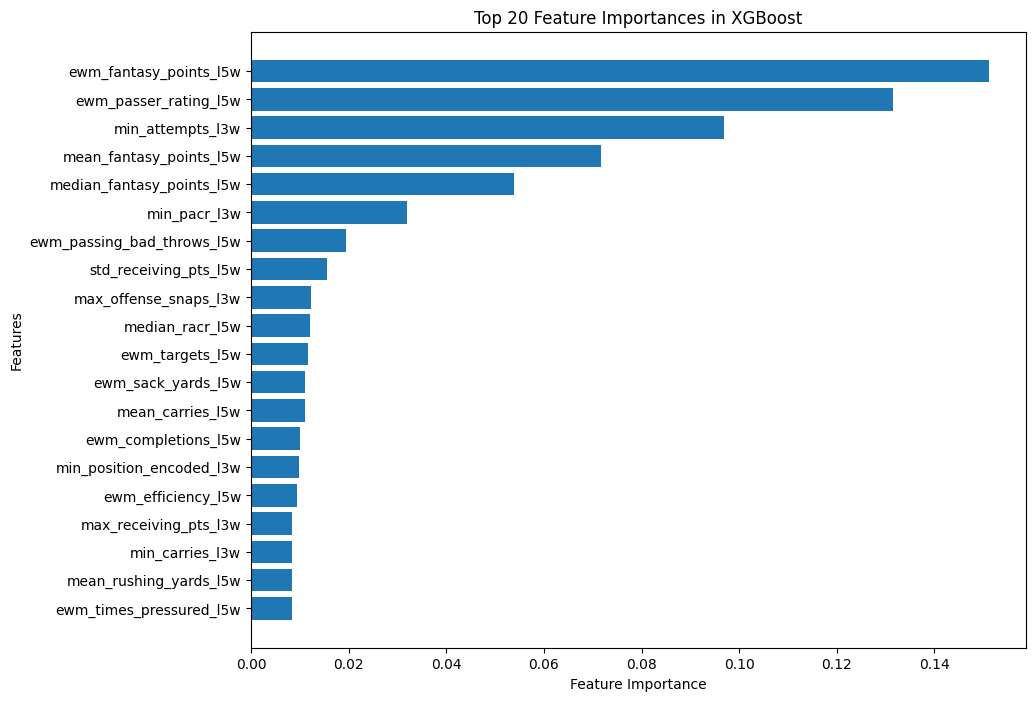

In [11]:
# Hole die Feature-Wichtigkeiten
feature_importances = bestModel.feature_importances_

# Erstelle ein DataFrame für Features und deren Wichtigkeiten
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sortiere die Feature-Wichtigkeiten absteigend
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Wähle die Top 20 Features
top_features = feature_importance_df.head(20)

# Plotten der Feature-Wichtigkeiten
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.gca().invert_yaxis()  # Um die höchste Wichtigkeit oben anzuzeigen
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importances in XGBoost")
plt.show()

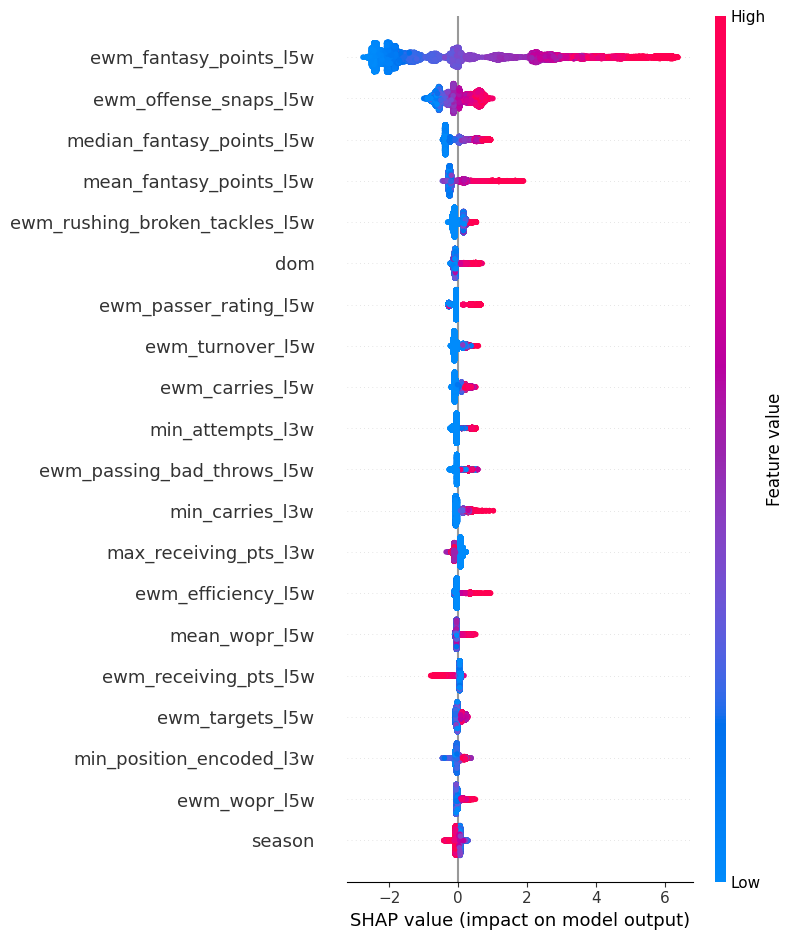

In [12]:
import shap

# Berechne SHAP-Werte
explainer = shap.TreeExplainer(bestModel)
shap_values = explainer.shap_values(X_train)

# Plot der Feature-Wichtigkeit
shap.summary_plot(shap_values, X_train)


In [13]:
# Vorhersage für 2024
y_pred_2024 = rfe.predict(X_test)

df_ids = df_ids.dropna(subset=['player_id'])
df_ids['player_id'] = df_ids['player_id'].str.replace('00-00', '').astype(int)
df_weekly['player_id'] = df_weekly['player_id'].str.replace('00-00', '').astype(int)


df_merged_2024 = pd.merge(df_merged[df_merged['season']==2024], df_ids[['name', 'player_id', 'position']], on = 'player_id', how = 'inner')
df_merged_2024 = pd.merge(df_merged_2024, df_weekly[['player_id', 'season', 'week', 'recent_team', 'opponent_team']], on = ['player_id', 'season', 'week'], how = 'inner')
df_merged_2024['predicted_fantasy_points'] = y_pred_2024

In [14]:
print('mean absolute error: ' + str(mean_absolute_error(y_test, rfe.predict(X_test))))
print('mean squared error: ' + str(mean_squared_error(y_test, rfe.predict(X_test))))
print('root mean squared error: ' + str(root_mean_squared_error(y_test, rfe.predict(X_test))))
print('r2 score: ' + str(r2_score(y_test, rfe.predict(X_test))))


from scipy.stats import spearmanr
# Erstelle eine Rangliste basierend auf predicted und tatsächlichen Punkten und berechne die Spearman-Rangkorrelation
rank_predicted = pd.Series(rfe.predict(X_test)).rank(ascending=False)
rank_actual = pd.Series(y_test).rank(ascending=False)
spearman_corr, _ = spearmanr(rank_predicted, rank_actual)
print(f"Spearman-Rangkorrelation: {spearman_corr:.2f}")


# Spearman-Rangkorrelation nach Position und Woche
results = []
# Gruppieren nach Position und Woche
for (position, week), group in df_merged_2024.groupby(['position', 'week']):
    # Erstelle Ranglisten
    rank_predicted = group['predicted_fantasy_points'].rank(ascending=False)
    rank_actual = group['fantasy_points'].rank(ascending=False)
    
    # Berechne Spearman-Rangkorrelation
    if len(group) > 1:  # Nur berechnen, wenn mehr als 1 Spieler in der Gruppe ist
        spearman_corr, _ = spearmanr(rank_predicted, rank_actual)
        results.append({'Position': position, 'Week': week, 'Spearman Correlation': spearman_corr})
    else:
        results.append({'Position': position, 'Week': week, 'Spearman Correlation': None})  # Zu wenige Daten
df_results = pd.DataFrame(results)
print(df_results)

mean absolute error: 4.1037207
mean squared error: 31.102694
root mean squared error: 5.5769787
r2 score: 0.396820604801178
Spearman-Rangkorrelation: 0.62
   Position  Week  Spearman Correlation
0        QB     1              0.714548
1        QB     2              0.488410
2        QB     3              0.408962
3        QB     4              0.533384
4        QB     5              0.678398
5        QB     6              0.584427
6        QB     7              0.666484
7        QB     8              0.267532
8        QB     9              0.448128
9        QB    10              0.641263
10       QB    11              0.106498
11       QB    12              0.590963
12       QB    13              0.171053
13       QB    14              0.826613
14       QB    15              0.578039
15       QB    16              0.371689
16       QB    17              0.652533
17       QB    18              0.397793
18       RB     1              0.599761
19       RB     2              0.762618
20   

In [15]:
# CSV-Datei mit den notwendigen Spalten
df_output = df_merged_2024[['player_id', 'name', 'position', 'season', 'week', 'recent_team', 'opponent_team', 'predicted_fantasy_points', 'fantasy_points']]
df_output.to_csv('fantasy_points_predictions_2024.csv', index=False)